# Run Time Assurance Framework Tutorial

### Kyle Dunlap, Umberto Ravaioli, and Kerianne Hobbs

This tutorial provides an example for how to use the AFRL Safe Autonomy Run Time Assurance Framework. This framework provides a standard baseline for designed RTA systems in Python with minimal user effort. [JAX](https://jax.readthedocs.io/en/latest/index.html) is used for automatic differentiation, allowing for easy gradient and jacobian computation.

The associated paper can be found on [arXiv](https://arxiv.org/pdf/2209.01120.pdf).

To begin, import packages.

In [2]:
import numpy as np
import jax.numpy as jnp
from collections import OrderedDict
import matplotlib.pyplot as plt

from run_time_assurance.constraint import ConstraintModule, PolynomialConstraintStrengthener
from run_time_assurance.controller import RTABackupController
from run_time_assurance.rta import ExplicitASIFModule, ExplicitSimplexModule, ImplicitASIFModule, ImplicitSimplexModule

# Problem Definition

This example considers the simple example of a [double integrator](http://liberzon.csl.illinois.edu/teaching/cvoc/node85.html). A car begins at an initial position $x<0$, and attempts to move towards the goal state of $x=0$.

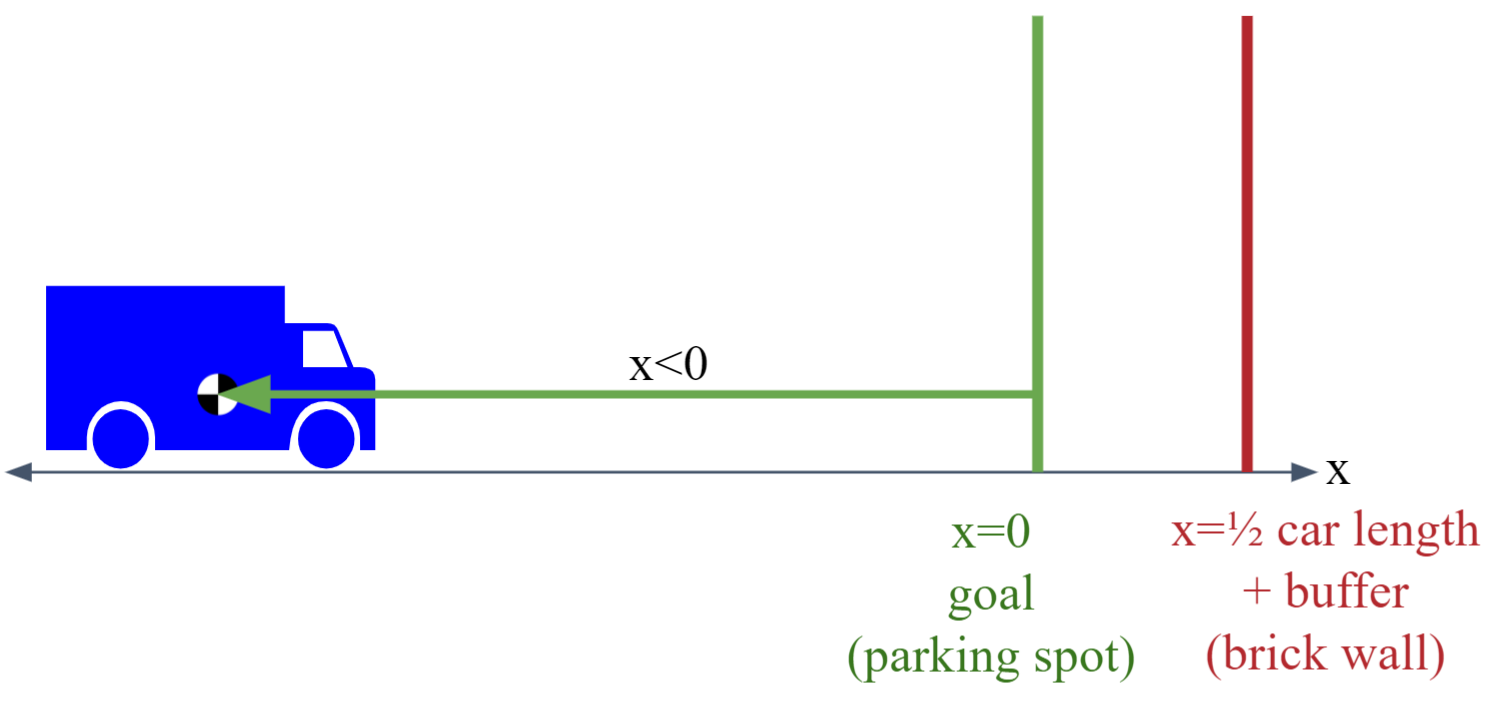

The car is represented with a position $x \in \mathbb{R}$ (bounded along the x-axis with no y component) with a bounded acceleration control variable $\ddot{x}=u, u\in[u_{min},u_{max}]$ (negative acceleration is braking). Let us assume that $u\in[-1,1]$

Our system state is the position $x$ and velocity $\dot{x}$ of the car:

\begin{equation}
\mathbf{x} = \begin{bmatrix}x_1\\x_2\end{bmatrix}=\begin{bmatrix}x\\\dot{x}\end{bmatrix}.
\end{equation}

This results in dynamics described by these state space equations:

\begin{equation}
\dot{x}_1 = x_2 
\end{equation}

\begin{equation}
\dot{x}_2 = u 
\end{equation}

In matrix form $\dot{\mathbf{x}} = A\mathbf{x}+B\mathbf{u}$, this becomes:

\begin{equation}
\dot{\mathbf{x}} = \begin{bmatrix}0 & 1\\ 0 & 0\end{bmatrix}\mathbf{x}+\begin{bmatrix}0\\1\end{bmatrix}\mathbf{u}
\end{equation}

# RTA

This tutorial will create four different classes of constraint-based RTA to safely complete the double integrator task: Explicit Simplex, Implicit Simplex, Explicit ASIF, and Implicit ASIF. Explicit approaches define safety offline using specific system parameters, while implicit approaches define safety online using trajectories under a backup control law. Simplex approaches are a simple switch between a primary and backup controller, while ASIF approaches utilize Control Barrier Functions (CBFs) to intervene in a minimally invasive manner.

# User Inputs
To create a constraint-based RTA module using the framework, the user only needs to define the following components:


*   System Dynamics
*   Constraints
*   Backup Controller (not required for Explicit ASIF)

## System Dynamics

First, the user should define the system dynamics. The dynamics can be defined in many ways, and often the user may want to use an external simulator.

For this example, we will create a custom dynamics class. The user should define two specific types of information:


*   Next state propagation (required by Simplex and Implicit ASIF): This is used to estimate a future state of the system, given the current state and control. 
*   State transition derivatives (required by ASIF): This is used to construct barrier constraints. The functions $f(x)$ and $g(x)$ must be defined for the control-affine system model $\dot{x}=f(x)+g(x)u$.

Note that it is advantageous, but not always required, to define the dynamics in a way that is compatible with JAX autodifferentiation and JIT compilation. The dynamics are defined as follows, where `next_state` computes the next state using Euler integration, and `f_x` and `g_x` define the state transition derivatives. Also note that in this tutorial, solutions are not perfect due to inaccurate integration and gradient issues at the origin.

In [3]:
# Custom class
class IntegratorDynamics():
    
    def __init__(self):
        m = 1 # mass
        self.A = np.array([[0, 1], [0, 0]])
        self.B = np.array([[0], [1 / m]])

    def next_state(self, state, step_size, control):
        state_dot = self.A @ state + self.B @ control
        return state + state_dot * step_size

    def f_x(self, state):
        return self.A @ state

    def g_x(self, state):
        return self.B
    

## Constraints

The safety constraint for this problem is to ensure that the car does not collide with the wall. This is defined as: $x_1 \leq 0$.

For all contraint-based RTA, the user should define a constraint $h(x)$, where the constraint is satisfied when $h(x) \geq 0$. For this example, this results in $h(x)=-x_1$. The RTA framework contains a base class called the `ConstraintModule`, which can be used to easily set up the constraint. The user must use $h(x)$ to define the `_compute` method. 

For ASIF approaches, the user should also define a constraint strengthening function $\alpha(x)$, which should be continous, strictly increasing, and have the condition $\alpha(0)=0$. The RTA framework contains a class called the `PolynomialConstraintStrengthener`, which allows the user to easily define a polynomial function for $\alpha(x)$.

The constraint class for implicit approaches is defined as follows.

In [4]:
# Child class
class ConstraintCollisionImplicit(ConstraintModule):

    def __init__(self):
        # alpha = 10*x + 30*x^3
        alpha = PolynomialConstraintStrengthener([0, 10, 0, 30])
        super().__init__(alpha=alpha)

    def _compute(self, state, params):
        # -x1 >= 0
        x1 = state[0]
        return -x1

For explicit approaches, safety must be defined offline. The maximum distance that the car can travel before stopping $D_{dec}$ is computed using a deceleration of $\bar{a}$ in a variation of the standard braking or stopping equation,

\begin{equation}
    D_{dec} = \frac{x_2^2}{2\bar{a}}.
\end{equation}

Assuming that our backup control action is to apply a maximum deceleration of $u = \bar{a} = -1$, and solving for the maximum velocity $x_2$ for any required required $x_1 = D_{dec}$, gives
\begin{equation}
\begin{split}
    x_1 &= \frac{x_2^2}{2(-1)}\\
    x_2^2 &= -2x_1\\
    x_2 &= \sqrt{-2x_1}\\
\end{split}
\end{equation}
Intuitively, $x_2=\sqrt{-2x_1}$ represents the maximum velocity the car can travel at a given distance while safely approaching the origin. If this approach speed is exceeded, then there will not be sufficient distance to stop before a collision occurs. Therefore, the constraint becomes $h(x)=-2x_1-x_2^2$.

The constraint class for explicit approaches is defined as follows.

In [5]:
# Child class
class ConstraintCollisionExplicit(ConstraintModule):

    def __init__(self):
        # alpha = 1*x + 30*x^3
        alpha = PolynomialConstraintStrengthener([0, 1, 0, 30])
        super().__init__(alpha=alpha)

    def _compute(self, state, params):
        x1 = state[0]
        x2 = state[1]
        return -2 * x1 - x2**2

## Backup Controller
Finally, the user should define a backup controller. As stated in the previous section, the backup control action should apply maximum deceleration of $u=1$. The RTA framework contains a class called the `RTABackupController`, where the user should define the `_generate_control` method. In this case, the method returns the backup control action as an array, and `None` is passed as there is no `controller_state`.

In [6]:
# Child class
class BrakingBackupController(RTABackupController):

    def _generate_control(self, state, step_size, controller_state=None):
        return jnp.array([-1]), None

# Simulating the RTA

First, begin with a simple RTA class with no RTA. This class uses the `filter_control` method to return the primary control action.

In [7]:
# Custom class
class NoRTA():
    def filter_control(self, state, step_size, control):
        return control

We will then set up a simulator class, used to simulate an episode and plot the results. This includes a `reset` function to initialize the environment, `step` to simulate one time step, `simulate_episode` to simulate the primary controller, RTA filter, and plant for the entire episode, and `plotter` to setup the plots. Note that everything in this class should be customized to the user's desire, except for calling the method `rta.filter_control(state, step_size, control)`, where `state` and `control` are typically 1D NumPy arrays, and `step_size` is a float.

In [8]:
# Custom class
class Simulator():

    def __init__(self):
        self.delta_t = 0.02 # time step
        self.time = 4 # total time
        self.dynamics = IntegratorDynamics() # dynamics

    def reset(self):
        self.steps = 0 # Time steps
        x = np.array([-1.75, 0]) # Initial state
        done = False # Terminal condition
        return x, done

    def step(self, state, control):
        self.steps += 1
        # Take step using dynamics
        state = self.dynamics.next_state(state, self.delta_t, control)

        x1 = state[0]
        x2 = state[1]
        # Check terminal conditions
        done = False
        if x1 >= 0:
            print('Result: Crash')
            done = True
        elif abs(x1) <= 0.1 and abs(x2) <= 0.1:
            print('Result: Safely Stopped')
            done = True
        elif self.steps >= self.time/self.delta_t:
            print('Result: Time Limit')
            done = True

        return state, done

    def simulate_episode(self, rta):
        # Setup RTA
        self.rta = rta
        # Initialize environment
        state, done = self.reset()

        # Data tracking arrays
        state_array = [state]
        control_array = [np.array([1.])]

        while not done:
            # Desired controller
            control_des = np.array([1.])
            # RTA filter
            control_act = self.rta.filter_control(state, self.delta_t, control_des)
            # Plant
            state, done = self.step(state, control_act)

            # Track data
            state_array = np.append(state_array, [state], axis=0)
            control_array = np.append(control_array, [control_act], axis=0)

        # Plot data
        self.plotter(state_array, control_array)

    def plotter(self, state_array, control_array):
        fig = plt.figure(figsize=(20, 10))

        lim_x1 = np.linspace(-2, 0, 10000)
        lim_x2 = np.sqrt(-2*lim_x1)
        ax1 = fig.add_subplot(121)
        ax1.plot(lim_x1, lim_x2, 'k--', linewidth=2, label='Constraint')
        ax1.plot([0, 0], [-1, 0], 'k--', linewidth=2)
        ax1.plot(0, 0, 'k*', markersize=15, label='Desired State')
        ax1.fill_between(lim_x1, 0, lim_x2, color=(244/255, 249/255, 241/255)) # green
        ax1.fill_between(lim_x1, -1, 0, color=(244/255, 249/255, 241/255)) # green
        ax1.fill_between(lim_x1, lim_x2, 10, color=(255/255, 239/255, 239/255)) # red
        ax1.fill_between([0, 1], -1, 10, color=(255/255, 239/255, 239/255)) # red
        ax1.plot(state_array[0, 0], state_array[0, 1], 'b*', markersize=15, label='Initial State')
        ax1.plot(state_array[:, 0], state_array[:, 1], 'b', linewidth=2, label='Trajectory')
        ax1.set_xlim([-2, 0.1])
        ax1.set_ylim([-0.2, 2.2])
        ax1.set_xlabel(r'$x_1$ (position) [m]')
        ax1.set_ylabel(r'$x_2$ (velocity) [m/s]')
        ax1.set_title('Trajectory')
        ax1.grid(True)
        ax1.legend()

        ax2 = fig.add_subplot(122)
        xlim = len(control_array[:, 0]) * self.delta_t * 1.1
        ax2.plot([0, xlim], [1, 1], 'k--', linewidth=2)
        ax2.plot([0, xlim], [-1, -1], 'k--', linewidth=2)
        ax2.fill_between([0, xlim], -1, 1, color=(244/255, 249/255, 241/255)) # green
        ax2.fill_between([0, xlim], -2, -1, color=(255/255, 239/255, 239/255)) # red
        ax2.fill_between([0, xlim], 1, 2, color=(255/255, 239/255, 239/255)) # red
        ax2.plot(np.array(range(len(control_array[:, 0])))*self.delta_t, control_array[:, 0], 'b', linewidth=2)
        ax2.grid(True)
        ax2.set_xlim([0, xlim])
        ax2.set_ylim([-1.1, 1.1])
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('Control [N]')
        ax2.set_title('Control')    

Now, simulate an episode without RTA. See that the primary controller causes the car to crash.

Result: Crash


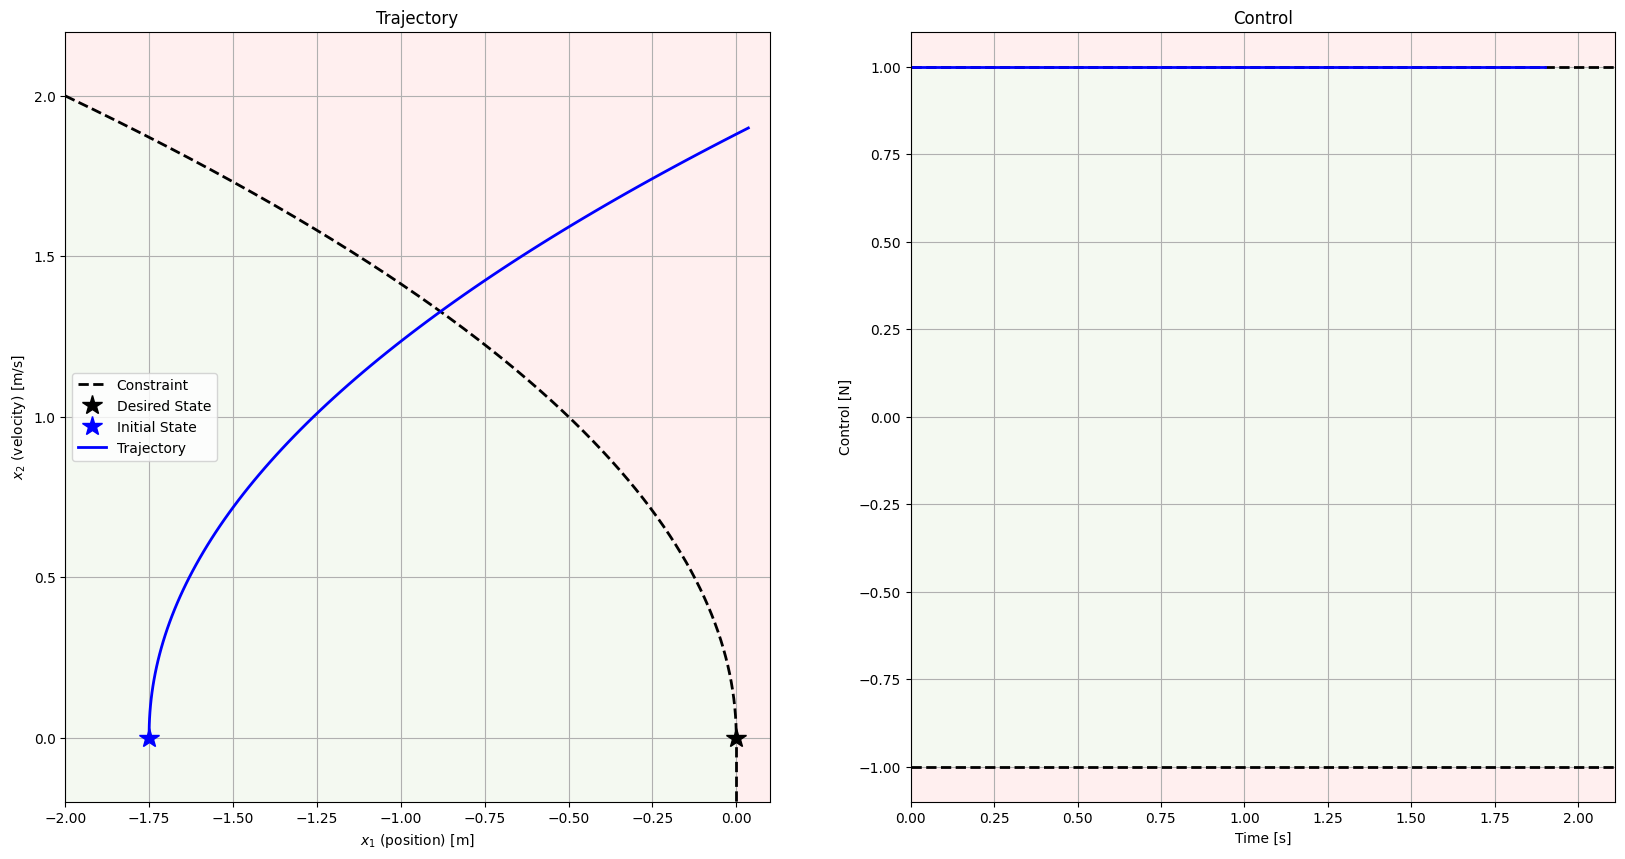

In [9]:
sim = Simulator()
rta = NoRTA()
sim.simulate_episode(rta)
plt.show()

## Explicit Simplex RTA

To create an explicit simplex RTA, use the `ExplicitSimplexModule`. The user should first define the minimum and maximum control bounds, initialize the previously defined backup controller, and create a `jit_compile_dict` (this allows the RTA to compile certain functions to speed up computation).
The user must then define the `_setup_constraints` method, where the previously defined constraint should be initialized within an `OrderedDict` (additional constraints can be added to the same dictionary. 
Finally, the user must define the `_pred_state` method, which predicts the next state of the system using the dynamics. Since this function was setup in a way that is compatible with JAX and JIT compilation, we set `'pred_state': True` in the `jit_compile_dict`.

In [10]:
# Child class
class IntegratorExplicitSimplexRTA(ExplicitSimplexModule):
    
    def __init__(self):
        u_max = 1

        self.dynamics = IntegratorDynamics()
        backup_controller = BrakingBackupController()
        jit_compile_dict = {'pred_state': True}

        super().__init__(control_bounds_high=u_max, control_bounds_low=-u_max, backup_controller=backup_controller, jit_compile_dict=jit_compile_dict)

    def _setup_constraints(self):
        return OrderedDict([('collision', ConstraintCollisionExplicit())])

    def _pred_state(self, state, step_size, control):
        return self.dynamics.next_state(state, step_size, control)

Next, simulate an episode using the explicit simplex RTA.

Result: Safely Stopped


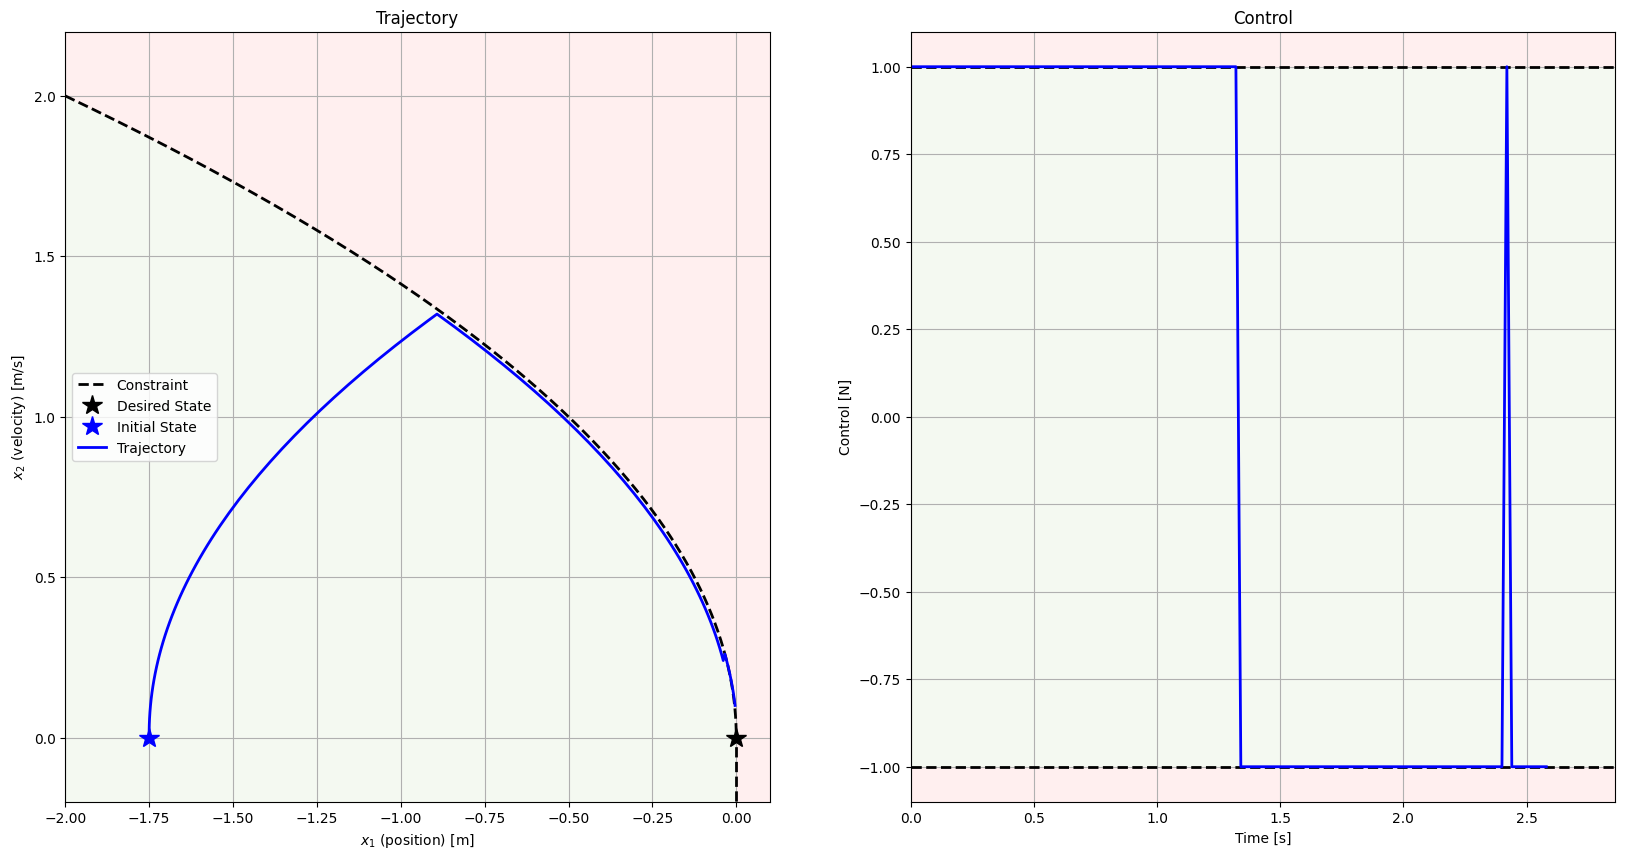

In [11]:
sim = Simulator()
rta = IntegratorExplicitSimplexRTA()
sim.simulate_episode(rta)
plt.show()

## Implicit Simplex RTA

To create an implicit simplex RTA, use the `ImplicitSimplexModule`. The user should first define the minimum and maximum control bounds, initialize the previously defined backup controller, create a `jit_compile_dict`, and define a backup window (length of time to compute the backup trajectory).
Again, the user must then define the `_setup_constraints` method and the `_pred_state` method. Since the dynamics were setup in a way that is compatible with JAX and JIT compilation, we set `'pred_state': True` and `'integrate': True` in the `jit_compile_dict`.

In [12]:
# Child class
class IntegratorImplicitSimplexRTA(ImplicitSimplexModule):

    def __init__(self):
        u_max = 1
        backup_window = 2

        self.dynamics = IntegratorDynamics()
        backup_controller = BrakingBackupController()
        jit_compile_dict = {'pred_state': True, 'integrate': True}

        super().__init__(backup_window=backup_window, backup_controller=backup_controller, control_bounds_high=u_max, control_bounds_low=-u_max, jit_compile_dict=jit_compile_dict)

    def _setup_constraints(self):
        return OrderedDict([('collision', ConstraintCollisionImplicit())])

    def _pred_state(self, state, step_size, control):
        return self.dynamics.next_state(state, step_size, control)


Next, simulate an episode using the implicit simplex RTA.

Result: Safely Stopped


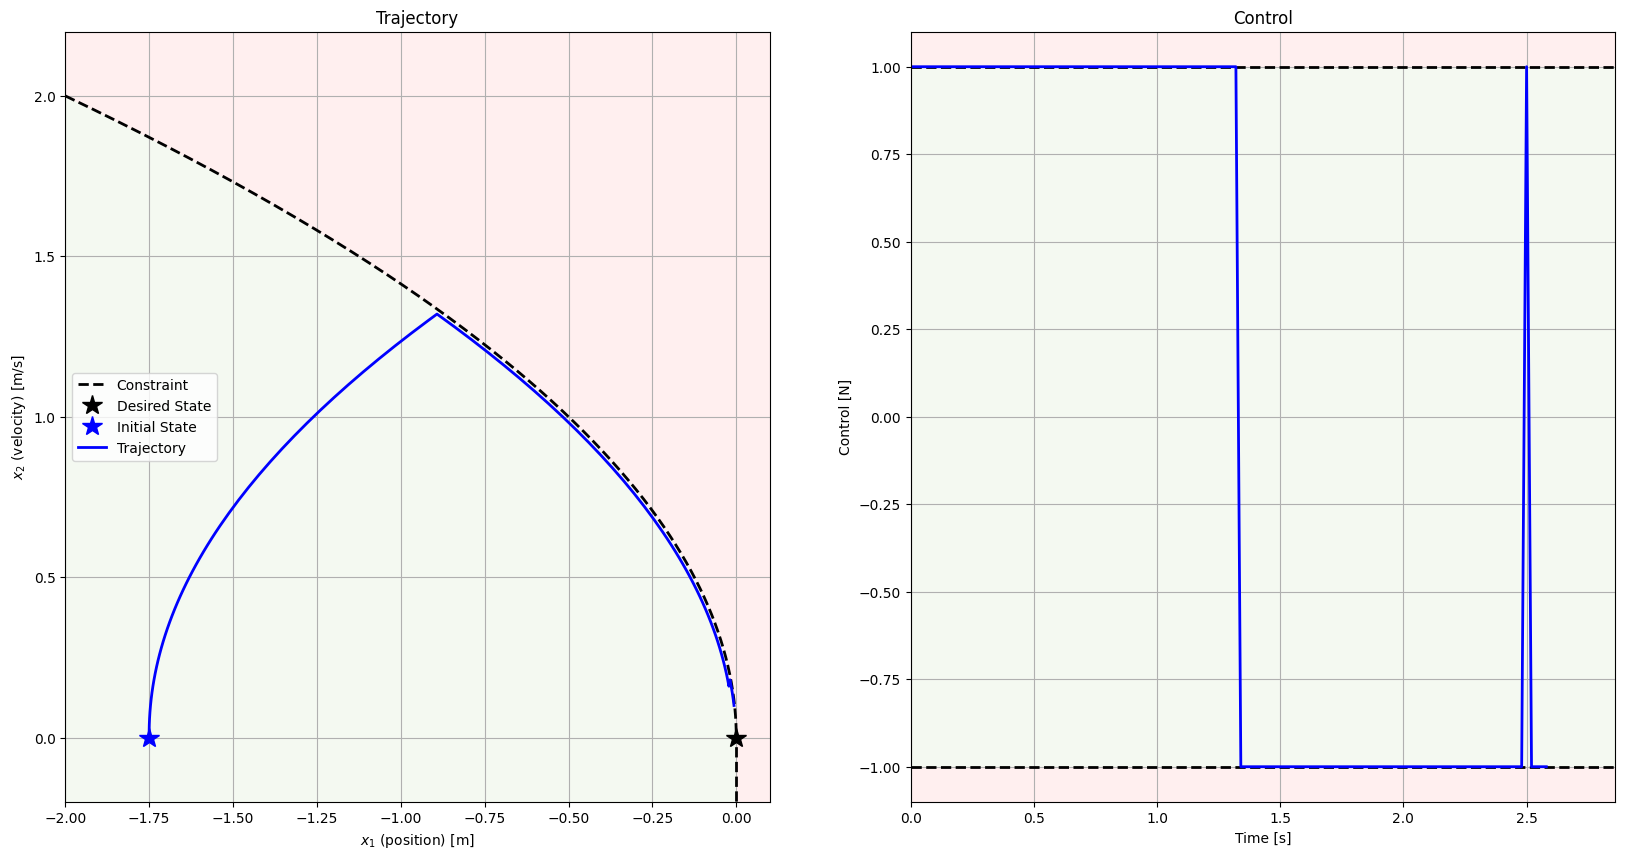

In [13]:
sim = Simulator()
rta = IntegratorImplicitSimplexRTA()
sim.simulate_episode(rta)
plt.show()

## Explicit ASIF RTA

To create an explicit ASIF RTA, use the `ExplicitASIFModule`. The user should first define the minimum and maximum control bounds, and the `control_dim` (length of the control vector, in this case 1).
Again, the user must then define the `_setup_constraints` method and the `_pred_state` method (Future versions of `run-time-assurance` will eliminate the need to define `_pred_state` for explicit ASIF, but simply adding a pass statement is sufficient in this case). Finally, the user must define JAX compatible methods `state_transition_system` and `state_transition_input`.

In [14]:
# Child class
class IntegratorExplicitASIFRTA(ExplicitASIFModule):

    def __init__(self):
        u_max = 1
        self.dynamics = IntegratorDynamics()

        super().__init__(control_bounds_high=u_max, control_bounds_low=-u_max, control_dim=1)

    def _setup_constraints(self):
        return OrderedDict([('collision', ConstraintCollisionExplicit())])

    def _pred_state(self, state, step_size, control):
        pass

    def state_transition_system(self, state):
        return self.dynamics.f_x(state)

    def state_transition_input(self, state):
        return self.dynamics.g_x(state)


Next, simulate an episode using the explicit ASIF RTA.

Result: Safely Stopped


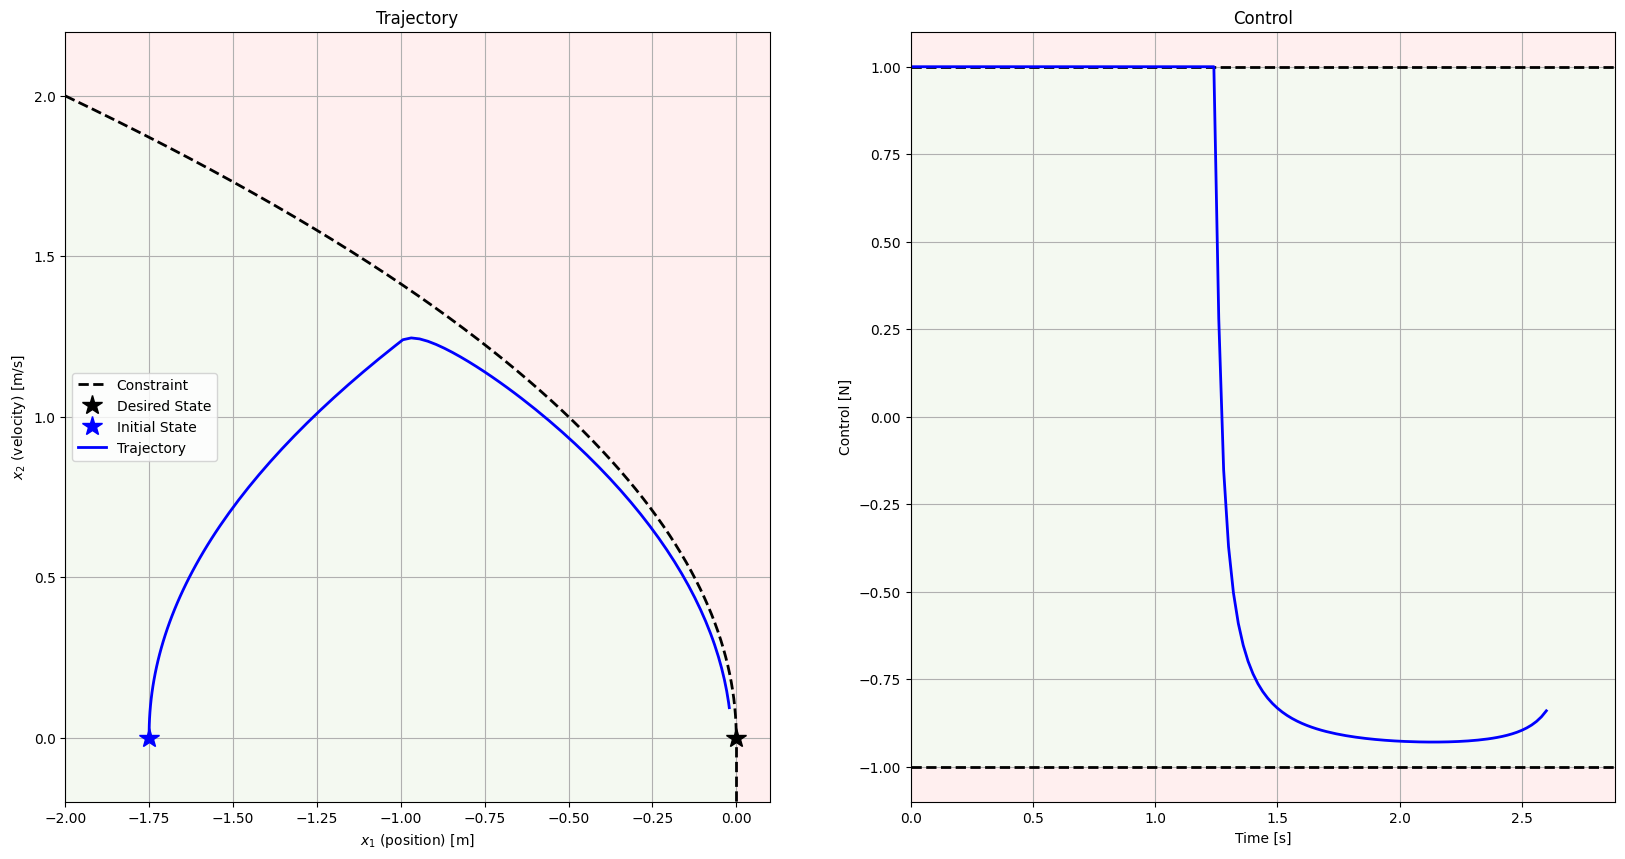

In [15]:
sim = Simulator()
rta = IntegratorExplicitASIFRTA()
sim.simulate_episode(rta)
plt.show()

## Implicit ASIF RTA

To create an implicit ASIF RTA, use the `ImplicitASIFModule`. The user should first define the minimum and maximum control bounds, define the `control_dim`, create a `jit_compile_dict`, initialize the previously defined backup controller, define the backup window, and define multiple trajectory related parameters. For a trajectory consisting of `n` steps, these parameters include `num_check_all` (first `m` steps at the beginning of the trajectory to create barrier constraints for) and `skip_length` (number of steps `s` to skip when creating barrier constrains for steps `m:s:n`). In this case, `num_check_all=0` and `skip_length=1` causing barrier constraints to be created for all points along the trajectory.
Again, the user must then define the `_setup_constraints`, `_pred_state`, `state_transition_system`, and `state_transition_input` methods.

In [18]:
# Child class
class IntegratorImplicitASIFRTA(ImplicitASIFModule):

    def __init__(self):
        u_max = 1
        backup_window = 2

        self.dynamics = IntegratorDynamics()
        backup_controller = BrakingBackupController()
        jit_compile_dict = {'pred_state': True, 'integrate': True}

        super().__init__(backup_window=backup_window, backup_controller=backup_controller, control_bounds_high=u_max, control_bounds_low=-u_max, control_dim=1, jit_compile_dict=jit_compile_dict)

    def _setup_constraints(self):
        return OrderedDict([('collision', ConstraintCollisionImplicit())])

    def _pred_state(self, state, step_size, control):
        return self.dynamics.next_state(state, step_size, control)

    def state_transition_system(self, state):
        return self.dynamics.f_x(state)

    def state_transition_input(self, state):
        return self.dynamics.g_x(state)


Next, simulate an episode using the implicit ASIF RTA.

Result: Safely Stopped


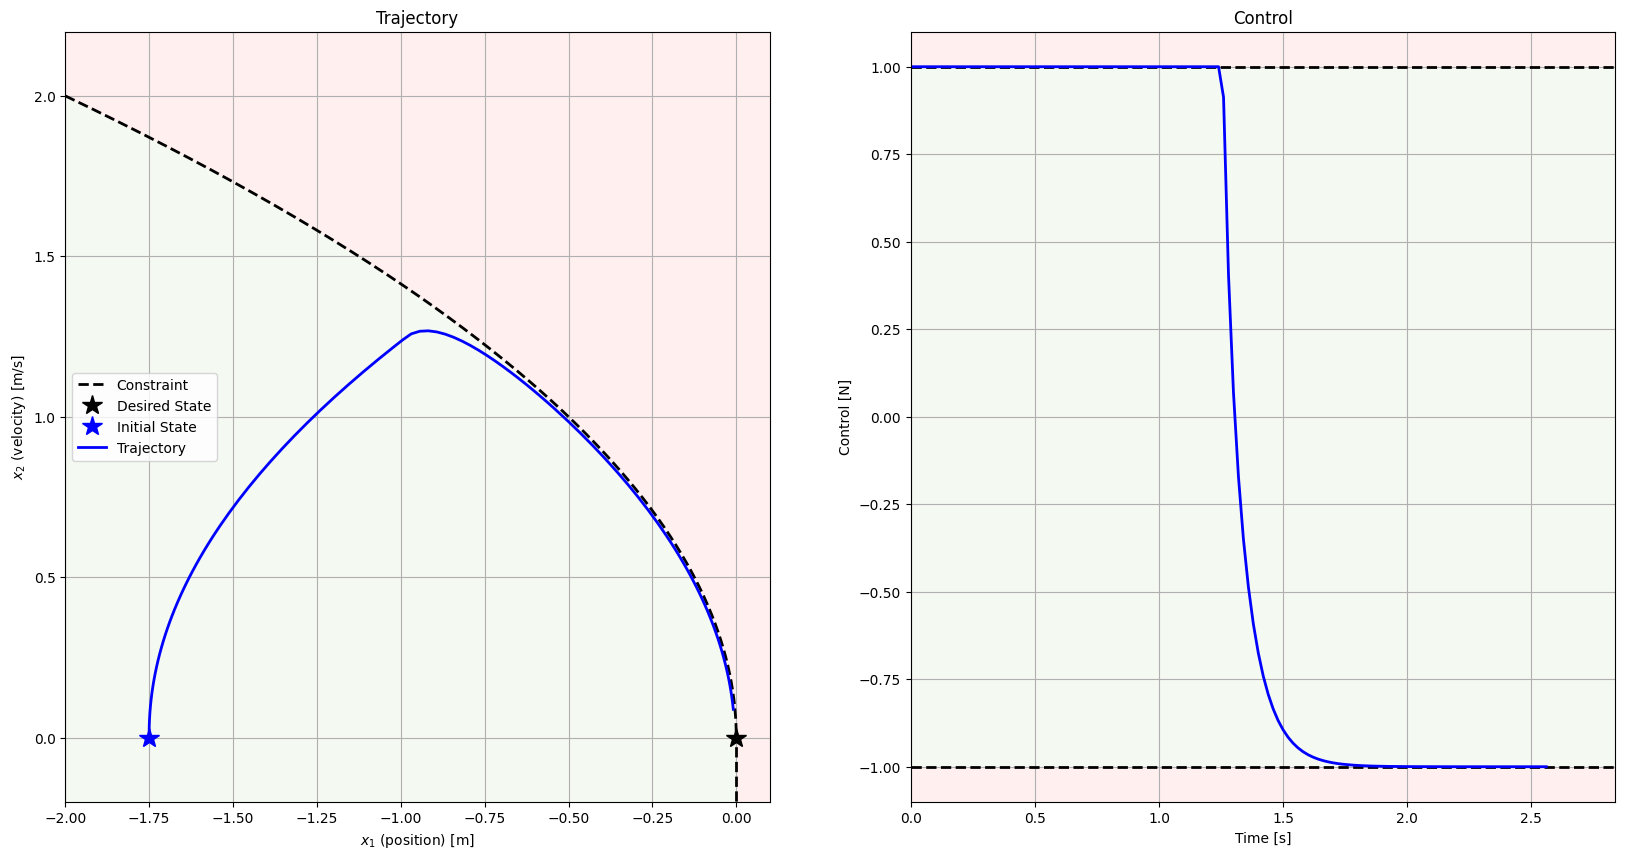

In [19]:
sim = Simulator()
rta = IntegratorImplicitASIFRTA()
sim.simulate_episode(rta)
plt.show()

# Conclusion
This tutorial provides a simple example for how to use the RTA framework. The RTA framework provides an easy to use, standard interface for creating RTA systems. In particular, it is a powerful tool for creating ASIF RTA systems, where gradients and jacobians are automatically calculated and used to create all barrier constraints.